In [1]:
import numpy as np
import emcee
from matplotlib import pyplot as plt
from operator import itemgetter
from scipy.stats import uniform, norm
from scipy.integrate import quad, simpson
from scipy.interpolate import interp1d
from functools import reduce
from os.path import join, abspath
from os import pardir, mkdir
import sys
import vaex

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

In [22]:
from utils import log_nu_mod

In [3]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [4]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_number_dir = join(root_data_dir, "Number-Density")
data_velocity_dir = join(root_data_dir, "Spectral-Class-Velocity")
data_comp_dir = join(root_data_dir, "Effective-Volume")

In [7]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


# Math

let $Z=\{z_i\}$ is a collection of vertical positions of the stars, and $W=\{w_i\}$ is a collection of vertical velocities of the stars. We assume that the vertical positions and velocities are independent. $Z$ and $W$ are inhomogeneous Poisson processes with intensity $\lambda(z)$ and $\mu(w)$ respectively. The intensity $\lambda(z)$ is the number density of star in vertical direction, and $\mu(w)$ is the number density of stars at some velocity $w$.

From previous notebook, the intensity $\lambda(z)$ can be calculated depent on the following parameters $\theta$:
* $\rho_{i}$ - the density of the baryons
* $\sigma_{z,i}$ - baryons velocity dispersion in vertical direction
* $\rho_{\text{DM}}$ - the density of the dark matter halo in the vicinity of the sun
* $\Sigma_{\text{DD}}$ - surface density of dark disk
* $h_{\text{DD}}$ - the vertical scale height of dark disk
* $\nu_0$ - the number density of stars in the midplane disk
* $z_{\odot}$ - the position of the sun
* $R$ - Oort constant radial contribution
* $\sigma_w$ - the velocity dispersion of the stars in vertical direction
* $w_0$ - the velocity of the sun

So,
\begin{aligned}
  \lambda (z) &= f(z;\theta) \\
  &= \nu(z;\theta) \mathcal{F} (z) \\
  &= \nu_0 \exp \left[ -\frac{\Phi(z+z_{\odot};\rho_i,\sigma_{z,i}, \rho_{\text{DM}}, \Sigma_{\text{DD}}, h_{\text{DD}}, R )}{\sigma_w^2} \right] \mathcal{F} (z)\\
\end{aligned}

Where $\mathcal{F} (z)$ is the completeness function

and the same goes for the intensity $\mu(w)$:
\begin{aligned}
  \mu (w) &= g(w;\theta) \\
  &= \mathcal{N}(w;\sigma_w, w_0)
\end{aligned}

# Framework

by using Bayesian Statistics, we can calculate the posterior distribution of the parameters $\theta$ given the data $Z$ and $W$:
\begin{aligned}
  p_\text{pos}(\theta|Z,W) &= \frac{p_\text{like}(Z,W|\theta)p_\text{prior}(\theta)}{p_\text{ev}(Z,W)} \\
  &\propto p_\text{like,Z}(Z|\theta)p_\text{like,W}(W|\theta) p_0(\theta) \\
  &\propto \mathcal{L}_z(Z|\theta)\mathcal{L}_w(W|\theta) p_0(\theta) \\
  \text{log } p_\text{pos}(\theta|Z,W) &= \text{log } \mathcal{L}_z(Z|\theta) + \text{log } \mathcal{L}_w(W|\theta) + \text{log } p_0(\theta) + C\\
\end{aligned}

Where the likelihood is the likelihood of inhomogeneous Poisson process,
\begin{aligned}
  \text{log } \mathcal{L}_z(Z|\theta) &= \sum_i \log \lambda(z_i) - \int \lambda(z) \text{ d}z \\
  \text{log } \mathcal{L}_w(W|\theta) &= \sum_i \log \mu(w_i) - \int \mu(w) \text{ d}w \\
\end{aligned}

### Prior

Either we can use a uniform prior or a Gaussian prior. The uniform prior is represented by [lower, upper].
| Parameter | Prior | Description |
| --- | --- | --- |
| $\rho_{i}$ | Gaussian | Check the baryons table |
| $\sigma_{z,i}$ | Gaussian | Check the baryons table |
| $\rho_{\text{DM}}$ | [0, 0.06] msun/pc^3 |  |
| $\Sigma_{\text{DD}}$ | [0, 30] msun/pc^2 | |
| $h_{\text{DD}}$ | [0, 100] pc |  |
| $\text{log }\nu_0$ | [12, 13] | A star (star/kpc^3) |
|  | [14, 14.4] | F star |
|  | [13.8, 14] | G star |
| $z_{\odot}$ | [-50, 50] pc | |
| $R$ | Gaussian | mean=3.4E-3, std=0.6E-3 in msun/pc^3|
| $\sigma_w$ | [1, 20] km/s | |
| $w_0$ | [-20, 20] km/s | |

In [18]:
def log_prior(theta, locs, scales):
  args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'logNu0', 'zsun', 'R', 'sigma_w', 'w0')
  rhos, sigmaz, rhoDM, sigmaDD, hDD, logNu0, zsun, R, sigma_w, w0 = itemgetter(*args)(theta)
  args = ('rhos_loc', 'sigmaz_loc', 'rhoDM_loc', 'sigmaDD_loc',  'hDD_loc', 'logNu0_loc', 
          'zsun_loc', 'R_loc', 'sigma_w_loc', 'w0_loc')
  rhos_loc, sigmaz_loc, rhoDM_loc, sigmaDD_loc, hDD_loc, logNu0_loc, zsun_loc, R_loc, sigma_w_loc, w0_loc = itemgetter(*args)(locs)
  args = ('rhos_scale', 'sigmaz_scale', 'rhoDM_scale', 'sigmaDD_scale', 'hDD_scale', 'logNu0_scale',
          'zsun_scale', 'R_scale', 'sigma_w_scale', 'w0_scale')
  rhos_scale, sigmaz_scale, rhoDM_scale, sigmaDD_scale, hDD_scale, logNu0_scale, zsun_scale, R_scale, sigma_w_scale, w0_scale = itemgetter(*args)(scales)
  uni_loc = np.array([rhoDM_loc, sigmaDD_loc, hDD_loc, logNu0_loc, zsun_loc, sigma_w_loc, w0_loc])
  uni_scale = np.array([rhoDM_scale, sigmaDD_scale, hDD_scale, logNu0_scale, zsun_scale, sigma_w_scale, w0_scale])
  uni_val = rhoDM, sigmaDD, hDD, logNu0, zsun, sigma_w, w0
  log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
  result = (np.sum(norm.logpdf(rhos, loc=rhos_loc, scale=rhos_scale))
           +np.sum(norm.logpdf(sigmaz, loc=sigmaz_loc, scale=sigmaz_scale))
           +norm.logpdf(R, loc=R_loc, scale=R_scale)
           +log_uni)
  return result

In [19]:
# test log_prior
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
zsun = 0 # pc
hDD = 65 # pc
logNu0 = 12.3
zsun = 0.00 # pc
R = 3.4E-3 # Msun/pc^3
sigma_w = 5
w0 = -7

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, logNu0=logNu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0)

locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=0, sigmaDD_loc=0, hDD_loc=0, logNu0_loc=12, zsun_loc=-0.05, R_loc=3.4E-3, sigma_w_loc=1, w0_loc=-20)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=0.06, sigmaDD_scale=30, hDD_scale=100, logNu0_scale=1, zsun_scale=0.1, R_scale=0.6E-3, sigma_w_scale=19, w0_scale=40)

log_prior(theta, locs, scales)

58.46820153751294

In [47]:
import time

def log_likelihood(theta, z, w, comp_z, method='simpson'):
  # t0 = time.time()
  integral_nu = 0
  nu_f = lambda x: np.exp(log_nu_mod(x, theta)*comp_z(x))
  if method == 'quad':
    integral_nu, _ = quad(nu_f, np.min(z), np.max(z))
  else:
    zz = np.linspace(np.min(z), np.max(z), 1000)
    nus = nu_f(zz)  
    integral_nu = simpson(nus, zz)
  # t1 = time.time()
  # print("integral: ", t1-t0)
  log_nu = np.sum(log_nu_mod(z, theta)+np.log(comp_z(z)))
  # plt.plot(z, log_nu_mod(z, theta)+np.log(comp_z(z)))
  # print("log_nu: ", t2-t1)

  mu_f = lambda x: norm.pdf(x, loc=theta['w0'], scale=theta['sigma_w'])
  integral_mu, _ = quad(mu_f, np.min(w), np.max(w))
  # t3 = time.time()
  # print("integral: ", t3-t2)
  log_mu = np.sum(norm.logpdf(w, loc=theta['w0'], scale=theta['sigma_w']))
  # t4 = time.time()
  # print("log_mu: ", t4-t3)
  return log_nu-integral_nu+log_mu-integral_mu

In [48]:
# Test likelihood

tipe = "A"

df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))
df_velocity = vaex.open(join(data_velocity_dir, f"{tipe}-type.hdf5"))
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

z = df_number.z.to_numpy()
w = df_velocity.w.to_numpy()
comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
comp_z = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')

log_likelihood(theta, z, w, comp_z)

25598.515560209806

In [24]:
log_likelihood(theta, z, w, comp_z, method='quad')

<ipython-input-20-e266ebb07551>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_nu, _ = quad(nu_f, np.min(z), np.max(z))


26865.1194431862

In [46]:
def log_posterior(x, priors, data, comp_z):
  theta = dict(rhos=x[0:12], sigmaz=x[12:24], rhoDM=x[24], sigmaDD=x[25], hDD=x[26], logNu0=x[27], zsun=x[28], R=x[29], sigma_w=x[30], w0=x[31])
  locs, scales = itemgetter('locs', 'scales')(priors)
  z, w = itemgetter('z', 'w')(data)
  log_prior_ = log_prior(theta, locs, scales)
  if not np.isfinite(log_prior_):
      return -np.inf
  log_likelihood_ = log_likelihood(theta, z, w, comp_z, method='simpson')
  return log_prior_ + log_likelihood_

In [44]:
# Test posterior
x = np.array([*rhos, *sigmaz, rhoDM, sigmaDD, hDD, logNu0, zsun, R, sigma_w, w0])
priors = dict(locs=locs, scales=scales)
data = dict(z=z, w=w)
log_posterior(x, priors, data, comp_z)

25655.86775771594

Save relevant functions in utils.py

### Test prior, likelihood, and posterior from utils.py

In [5]:
from utils import log_prior, log_likelihood, log_posterior

In [8]:
# Test values
# test log_prior
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
zsun = 0 # pc
hDD = 65 # pc
logNu0 = 12.5
zsun = 0.00 # pc
R = 3.4E-3 # Msun/pc^3
sigma_w = 5
w0 = -7

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, logNu0=logNu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0)

locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=0, sigmaDD_loc=0, hDD_loc=0, logNu0_loc=12, zsun_loc=-0.05, R_loc=3.4E-3, sigma_w_loc=1, w0_loc=-20)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=0.06, sigmaDD_scale=30, hDD_scale=100, logNu0_scale=1, zsun_scale=0.1, R_scale=0.6E-3, sigma_w_scale=19, w0_scale=40)

log_prior(theta, locs, scales)

58.46820153751294

In [9]:
tipe = "A"

df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))
df_velocity = vaex.open(join(data_velocity_dir, f"{tipe}-type.hdf5"))
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

z = df_number.z.to_numpy()
w = df_velocity.w.to_numpy()
comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
comp_z = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')

log_likelihood(theta, z, w, comp_z)

25997.414947315316

In [10]:
x = np.array([*rhos, *sigmaz, rhoDM, sigmaDD, hDD, logNu0, zsun, R, sigma_w, w0])
priors = dict(locs=locs, scales=scales)
data = dict(z=z, w=w)
log_posterior(x, priors, data, comp_z)

26055.88314885283

# MCMC

In [11]:
name = "MCMC"
data_dir_mcmc = join(root_data_dir, name)
try:
  mkdir(data_dir_mcmc)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Directory already exist. Good to go!


In [12]:
# example mcmc
# np.random.seed(42)
ndim = 32
nwalkers = ndim*2

tipe = "A"

rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

rhos_0 = np.random.normal(loc=rhos, scale=e_rhos, size=(nwalkers, 12))
sigmaz_0 = np.random.normal(loc=sigmaz, scale=e_sigmaz, size=(nwalkers, 12))

rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)

sigmaDD_loc, sigmaDD_scale = 0, 30
sigmaDD_0 = np.random.uniform(low=sigmaDD_loc, high=sigmaDD_loc+sigmaDD_scale, size=nwalkers)

hDD_loc, hDD_scale = 0, 100
hDD_0 = np.random.uniform(low=hDD_loc, high=hDD_loc+hDD_scale, size=nwalkers)


logNu0_loc, logNu0_scale = 10, 10
logNu0_0 = np.random.uniform(low=logNu0_loc, high=logNu0_loc+logNu0_scale, size=nwalkers)

zsun_loc, zsun_scale = -0.05, 0.10
zsun_0 = np.random.uniform(low=zsun_loc, high=zsun_loc+zsun_scale, size=nwalkers)

R_loc, R_scale = 3.4E-3, 0.6E-3
R_0 = np.random.normal(loc=R_loc, scale=R_scale, size=nwalkers)

sigma_w_loc, sigma_w_scale = 1, 29
sigma_w_0 = np.random.uniform(low=sigma_w_loc, high=sigma_w_loc+sigma_w_scale, size=nwalkers)

w0_loc, w0_scale = -20, 40
w0_0 = np.random.uniform(low=w0_loc, high=w0_loc+w0_scale, size=nwalkers)

p0 = np.array([*rhos_0.T, *sigmaz_0.T, rhoDM_0, sigmaDD_0, hDD_0, logNu0_0, zsun_0, R_0, sigma_w_0, w0_0]).T

In [13]:
filename = join(data_dir_mcmc, "chain-A.hdf5")
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [14]:
locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=rhoDM_loc, sigmaDD_loc=sigmaDD_loc, hDD_loc=hDD_loc, 
            logNu0_loc=logNu0_loc, zsun_loc=zsun_loc, R_loc=R_loc, sigma_w_loc=sigma_w_loc, w0_loc=w0_loc)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=rhoDM_scale, sigmaDD_scale=sigmaDD_scale, 
              hDD_scale=hDD_scale, logNu0_scale=logNu0_scale, zsun_scale=zsun_scale, R_scale=R_scale, 
              sigma_w_scale=sigma_w_scale, w0_scale=w0_scale)
priors = dict(locs=locs, scales=scales)

df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))
df_velocity = vaex.open(join(data_velocity_dir, f"{tipe}-type.hdf5"))
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

z = df_number.z.to_numpy()
w = df_velocity.w.to_numpy()
comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
comp_z = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')
data = dict(z=z, w=w)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data, comp_z], backend=backend)

In [15]:
state = sampler.run_mcmc(p0, 100, progress=True)
state

100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


State([[ 7.24403964e-03  2.42626463e-02  7.36428427e-03 ...  3.30849929e-03
   4.70546060e+00 -7.02849891e+00]
 [ 8.69697765e-03  2.71039173e-02  7.49684120e-03 ...  3.19419463e-03
   4.90261533e+00 -6.15106853e+00]
 [ 9.05259804e-03  2.65966519e-02  7.41254307e-03 ...  3.30700070e-03
   5.01384212e+00 -7.59897136e+00]
 ...
 [ 7.92501987e-03  2.64833431e-02  7.47590399e-03 ...  3.14032592e-03
   4.92327065e+00 -7.40284618e+00]
 [ 8.76185345e-03  2.56938073e-02  7.54849899e-03 ...  3.26270471e-03
   4.82416382e+00 -6.68800193e+00]
 [ 5.22337776e-03  2.70322290e-02  7.09858267e-03 ...  3.15324757e-03
   5.24066529e+00 -9.18560036e+00]], log_prob=[29730.14729178 29671.61797141 29761.11708235 29731.68984253
 29750.87288199 29728.99942157 29686.17452473 29610.84619597
 29753.99630173 29751.38451895 29736.12826332 29735.87601206
 29750.60773165 29718.64487247 29772.13320288 29770.72700681
 29693.46686292 29734.33853353 29702.47427894 29735.07422216
 29748.71232537 26582.72798782 29681.768746

Text(0.5, 0, 'step number')

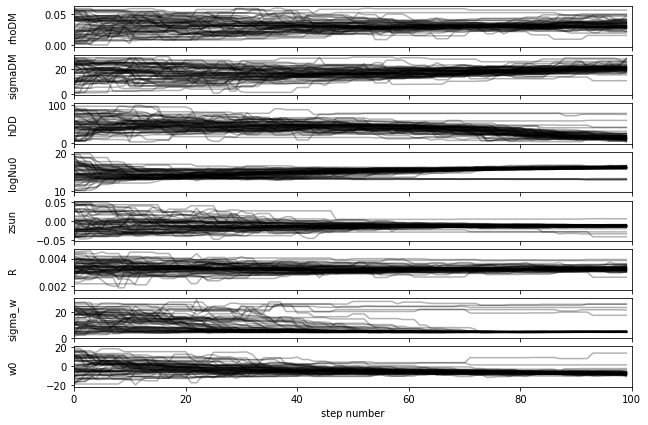

In [19]:
fig, axes = plt.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "logNu0", "zsun", "R", "sigma_w", "w0"]
for i in range(8):
    ax = axes[i]
    ax.plot(samples[:, :, i+24], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [20]:
import corner

flat_samples = sampler.get_chain(discard=0, flat=True)
flat_samples

array([[ 7.71691152e-03,  2.59991718e-02,  7.27415239e-03, ...,
         3.97997535e-03,  1.41170029e+00, -1.42269386e+01],
       [ 1.21978097e-02,  2.87276949e-02,  7.40287524e-03, ...,
         2.52046282e-03,  4.26661929e+00,  1.46442080e+01],
       [ 4.82867642e-03,  2.45444445e-02,  6.39963897e-03, ...,
         4.51669535e-03,  2.74661465e+01,  1.00179518e+01],
       ...,
       [ 7.92501987e-03,  2.64833431e-02,  7.47590399e-03, ...,
         3.14032592e-03,  4.92327065e+00, -7.40284618e+00],
       [ 8.76185345e-03,  2.56938073e-02,  7.54849899e-03, ...,
         3.26270471e-03,  4.82416382e+00, -6.68800193e+00],
       [ 5.22337776e-03,  2.70322290e-02,  7.09858267e-03, ...,
         3.15324757e-03,  5.24066529e+00, -9.18560036e+00]])

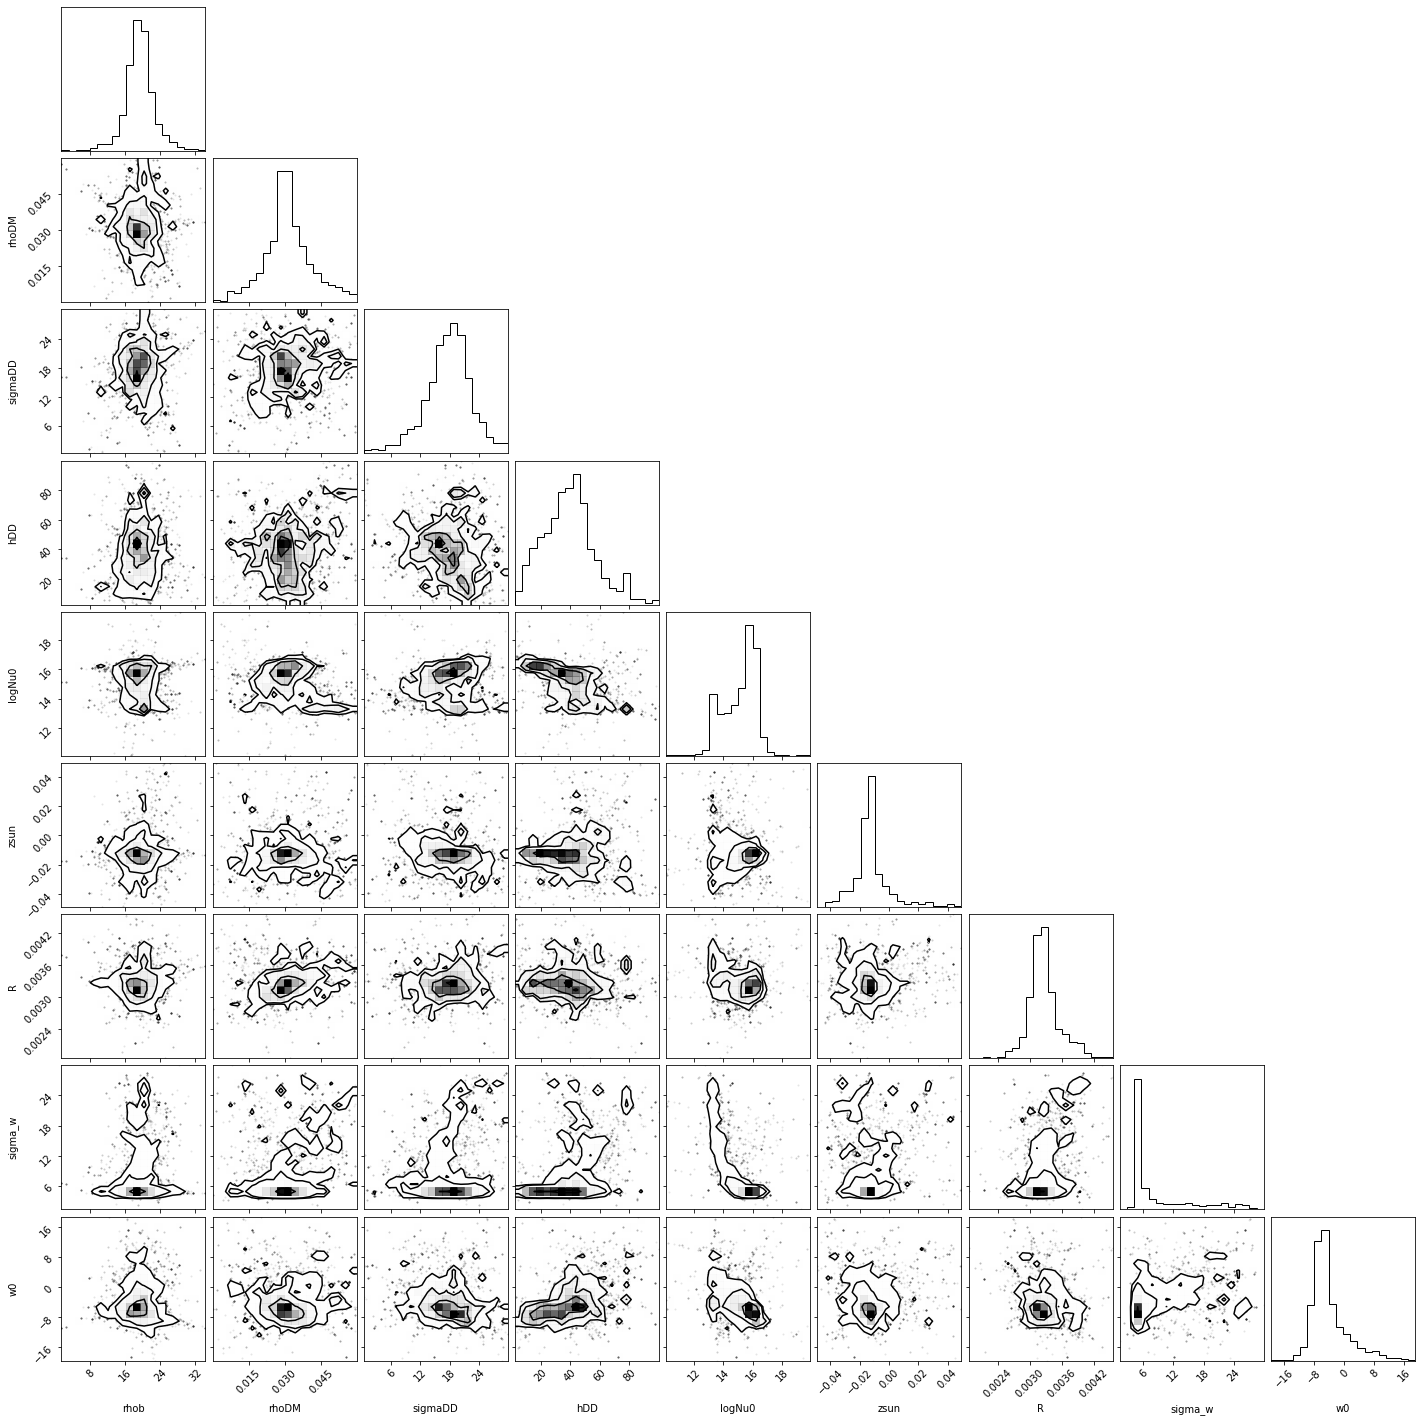

In [18]:
fig = corner.corner(
    flat_samples[:,23:], labels=["rhob", "rhoDM", "sigmaDD", "hDD", "logNu0", "zsun", "R", "sigma_w", "w0"],
)